# Part 1: data preparation (7 points)

The image files are in /scratch/lt2326-h21/a1/images on mltgpu. They are in jpg format. The code that you write for this part of the project should:

Use the info.json file to figure out what files are in the training set. You will just use the official training data for everything. Remember that you will only see a small minority of training examples in the images directory, for space reasons.
Divide up the official training data files into your own training, validation, and test datasets depending on your own preferences. You can choose to use fewer files than the maximum available if you run into problems with memory and so on (but first make sure your implementation is reasonably efficient).
Find the corresponding bounding box information in train.jsonl for each image.
You can represent the data in any way you like, but remember that it will become a numpy array for processing and a torch tensor for training. Remember also that the classes are defined by pixel: for each pixel, you will eventually have a set of features (e.g. colour values), and a binary class corresponding to whether the pixel was in a Chinese character bounding box or not (note that there are non-Chinese characters in the set -- see the annotation instructions). You are allowed to reduce the dimensionality of the images for processing, but consider using a pooling and/or upsampling technique in Part 2 of this assignment to accomplish this goal.

Describe the choices you made and the challenges you found in your report.

In [1]:
#imports

import json
import numpy as np
import pandas as pd
import random
from torch import nn
import os
import torch
from torchvision import transforms
from PIL import Image
from skimage import io

import matplotlib.path as mplpath
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mppath
from PIL import Image
import cv2


#device
device = torch.device('cuda:3')

https://realpython.com/working-with-files-in-python/

In [2]:
"""
findout if image files are part of the training dataset,in the info.json by comparing 
the image_id in both files 
"""

# open folder, loop through files, check if file in training set
with open("/scratch/lt2326-h21/a1/info.json", "r") as info_file:
    info = json.load(info_file)
# print(info.keys())
# print(info['train'][0])
# print(len(info['train']))

selecting_files = [i for i in info["train"]]
info_filenames = [x["image_id"] + ".jpg" for x in selecting_files]
# checking what images are in the images folder
all_images = os.listdir('/scratch/lt2326-h21/a1/images')
#figure out what files are in the training set
#There are 845 images in the image folder that come from the train file.
image_to_keep = [i for i in all_images if i in info_filenames]
print(len(image_to_keep))
print(type(image_to_keep))



845
<class 'list'>


https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

In [3]:
"""
I chose randomly splitting because I think it would be better if I evaluated
the model with new  data that hasn't been seen by the model before for the unbiased evaluation
"""
# create the train|test|valid data
from sklearn.model_selection import train_test_split
# In the first step we will split the data in training and remaining dataset
# Let's say we want to split the data in 80:10:10 for train:test:valid dataset
train_size = 0.8
train_data, rem_data = train_test_split(image_to_keep, train_size=0.8)
# Now since we want the valid and test size to be equal (10% each of overall data).
test_size = 0.5
test_data, valid_data = train_test_split(rem_data, test_size = 0.5)
 

print(len(train_data), len(test_data), len(valid_data))
print(test_data[0])

676 84 85
0000866.jpg


In [4]:
#extracting the same data which we have in image_to_keep from train_json

with open("/scratch/lt2326-h21/a1/train.jsonl","r") as train_file:
    train = [json.loads(x) for x in train_file]
#train[0]
#["file_name"] is the same as ["image_id"] + ".jpg"
usable_trainfile = [f for f in train if f["image_id"] + ".jpg" in image_to_keep]

#usable_trainfile = [f for f in train if f["file_name"] in info_filenames]

#print(usable_trainfile[0])


Find the corresponding bounding box information in train.jsonl for each image. You can represent the data in any way you like, but remember that it will become a numpy array for processing and a torch tensor for training.

https://matplotlib.org/stable/tutorials/introductory/images.html

In [5]:
image_dir = "/scratch/lt2326-h21/a1/images"
def find_polygon_imgarray(file):
    res_dic = {}
    res_list =[]
    polys = []
    array = []
    for line in usable_trainfile[:30]:
        file_name = line['file_name']
        if file_name in file:
            array_img = mpimg.imread(f"{image_dir}/{file_name}")   # convert to numpy array
            for l in line['annotations']:
                for i in l:
                    array.append(array_img)
                    if i['is_chinese'] == True:
                        polys.append(i["polygon"])
                        if line['file_name'] not in res_dic:
                            res_dic[line['file_name']] = []
                        res_dic[line['file_name']].append(i['polygon'])
            res_list.append((line['file_name'], polys))
                
                
    return(res_dic, res_list, array, polys)
                            

In [29]:
training_bb, data_n_p, array, polygons = find_polygon_imgarray(train_data)

In [30]:
#train_truth, valid_truth, test_truth = np.split(data_n_p, [int(len(usable_trainfile)*0.8), int(len(usable_trainfile)*0.9)])

In [68]:
#print(train_truth[0])

['0000172.jpg'
 list([[[140.26028096262758, 896.7550603352049], [162.42785410327272, 898.0769798344178], [162.42785410327272, 935.7929346470926], [140.26028096262758, 935.0939571156308]], [[162.42785410327272, 898.0769798344178], [185.80456759704398, 899.4710040335876], [185.80456759704398, 936.5300382257251], [162.42785410327272, 935.7929346470926]], [[185.80456759704398, 899.4710040335876], [207.5690939533138, 900.7688886328147], [207.5690939533138, 937.2163070747966], [185.80456759704398, 936.5300382257251]], [[207.5690939533138, 900.7688886328147], [227.7214331720821, 901.9706336320991], [227.7214331720821, 937.8517411943074], [207.5690939533138, 937.2163070747966]], [[235.37932207521408, 904.0339373539472], [254.3225209408563, 905.6048367720736], [254.3225209408563, 930.9507120129464], [235.37932207521408, 929.4576520038318]], [[254.3225209408563, 905.6048367720736], [268.42915839399416, 906.7746554876996], [268.42915839399416, 932.0625652112233], [254.3225209408563, 930.950712012

In [61]:
print(data_n_p[0])

('0000172.jpg', [[[140.26028096262758, 896.7550603352049], [162.42785410327272, 898.0769798344178], [162.42785410327272, 935.7929346470926], [140.26028096262758, 935.0939571156308]], [[162.42785410327272, 898.0769798344178], [185.80456759704398, 899.4710040335876], [185.80456759704398, 936.5300382257251], [162.42785410327272, 935.7929346470926]], [[185.80456759704398, 899.4710040335876], [207.5690939533138, 900.7688886328147], [207.5690939533138, 937.2163070747966], [185.80456759704398, 936.5300382257251]], [[207.5690939533138, 900.7688886328147], [227.7214331720821, 901.9706336320991], [227.7214331720821, 937.8517411943074], [207.5690939533138, 937.2163070747966]], [[235.37932207521408, 904.0339373539472], [254.3225209408563, 905.6048367720736], [254.3225209408563, 930.9507120129464], [235.37932207521408, 929.4576520038318]], [[254.3225209408563, 905.6048367720736], [268.42915839399416, 906.7746554876996], [268.42915839399416, 932.0625652112233], [254.3225209408563, 930.9507120129464]

In [62]:
print(polygons[0])
print(list(training_bb.keys())[0])  #file names
#print(list(training_bb.values())[0])  #polygons
#print(array[0])  #image array
#training_bb.keys(testing_bb[0])
#print(array[0]) #image array

[[140.26028096262758, 896.7550603352049], [162.42785410327272, 898.0769798344178], [162.42785410327272, 935.7929346470926], [140.26028096262758, 935.0939571156308]]
0000172.jpg


In [8]:
validation_bb, data_n_p2, array2, polygons2 = find_polygon_imgarray(valid_data)
testing_bb, data_n_p3, arrat3, polygons3 = find_polygon_imgarray(test_data)

In [6]:
%matplotlib inline

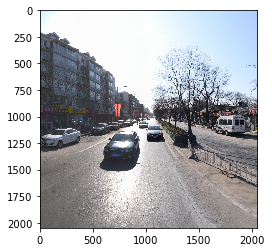

In [7]:
plt.imshow(array[0])

In [8]:
import matplotlib.pyplot as plt

In [9]:
print(array[0])

[[[223 242 255]
  [223 242 255]
  [223 242 255]
  ...
  [188 218 252]
  [187 218 249]
  [187 218 249]]

 [[223 242 255]
  [223 242 255]
  [223 242 255]
  ...
  [188 218 254]
  [187 217 251]
  [187 217 251]]

 [[223 242 255]
  [222 241 255]
  [222 241 255]
  ...
  [188 218 255]
  [188 218 254]
  [187 217 253]]

 ...

 [[111 102 103]
  [113 104 105]
  [113 104 105]
  ...
  [192 175 165]
  [190 173 163]
  [188 171 161]]

 [[115 106 107]
  [116 107 108]
  [115 106 107]
  ...
  [192 175 165]
  [191 174 164]
  [189 172 162]]

 [[116 106 107]
  [115 105 106]
  [112 103 104]
  ...
  [193 176 166]
  [192 175 165]
  [191 174 164]]]


In [9]:
training_bb, data_n_p, array, polygons = find_polygon_imgarray(train_data)

In [10]:
validation_bb, data_n_p2, array2, polygons2 = find_polygon_imgarray(valid_data)

In [11]:
testing_bb, data_n_p3, array3, polygons3  = find_polygon_imgarray(test_data)

In [12]:
def img_to_tensor(data):
    
    
    img = np.array(array)

    img = torch.Tensor(img)
  #  img = torch.tensor(img).float()
    
    return img 

In [13]:
#image_name = list(training_bb.keys())[0]
train_im_data = img_to_tensor(array)
valid_im_data = img_to_tensor(array2)
test_im_data = img_to_tensor(array3)


In [22]:
print(train_im_data[0])

tensor([[[222., 245., 253.],
         [221., 244., 252.],
         [220., 243., 251.],
         ...,
         [195., 226., 255.],
         [194., 225., 255.],
         [194., 225., 255.]],

        [[221., 244., 252.],
         [221., 244., 252.],
         [220., 243., 251.],
         ...,
         [177., 213., 249.],
         [180., 214., 251.],
         [182., 216., 253.]],

        [[221., 244., 252.],
         [220., 243., 251.],
         [220., 243., 251.],
         ...,
         [117., 156., 199.],
         [125., 164., 205.],
         [131., 168., 210.]],

        ...,

        [[ 98.,  94.,  91.],
         [101.,  97.,  94.],
         [104., 100.,  97.],
         ...,
         [187., 173., 162.],
         [187., 173., 162.],
         [187., 173., 162.]],

        [[104., 100.,  97.],
         [107., 103., 100.],
         [110., 106., 103.],
         ...,
         [189., 175., 164.],
         [190., 176., 165.],
         [190., 176., 165.]],

        [[107., 103., 100.],
       

In [14]:
def create_truthvalues(polygon, height = 2048, width = 2048, rescale = None):
    """ Builds a matrix of 0s and 1s representing the character polygons as 
        defined by the coordinates of in the CTW annotations. 
    """
    
    
    polygons = polygon
    if rescale != None:
        rescale_by = rescale / height # must come first
        height = rescale
        width = rescale
        polygons = [[[point * rescale_by for point in points] for points in set_of_points] for set_of_points in polygons]
    
    every_point = np.array([[[h,w] for h in list(range(height))] for w in list(range(width))]).reshape(height*width, 2)
    update_zero_points = np.zeros(height * width)
    update_zero_points.astype(bool)
    for polygon in polygons:
        path = mplpath.Path(np.array(polygon))
        hits = np.asarray(path.contains_points(every_point), int)
        update_zero_points += hits
    
    truthvals_mtrx = update_zero_points.reshape(height, width)
    
    return torch.tensor(truthvals_mtrx)





In [24]:
train_truthval = create_truthvalues(polygons, height = 2048, width = 2048, rescale = None)
valid_truthval = create_truthvalues(polygons2, height = 2048, width = 2048, rescale = None)
test_truthval = create_truthvalues(polygons3, height = 2048, width = 2048, rescale = None)

https://pytorch.org/docs/stable/generated/torch.reshape.html

In [17]:
#train_truthval = train_truthval[:676]
#valid_truthval = valid_truthval[:85]
#test_truthval = test_truthval[:84]

In [23]:
print(train_truthval[:10])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


torch.save(x, 'tensor.pt')

In [25]:
torch.save(train_truthval, 'train_truthval.pt')

In [26]:
torch.save(valid_truthval, 'valid_truthval.pt')

In [27]:
torch.save(test_truthval, 'test_truthval.pt')

In [16]:
torch.save(train_im_data, 'train_im_data.pt')
torch.save(valid_im_data, 'valid_im_data.pt')
torch.save(test_im_data, 'test_im_data.pt')

In [135]:
#print(train_truthval[:8])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


In [ ]:
train_truthval = torch.load('train_truthval.pt')
train_im_data = torch.load('train_im_data.pt')
print('train tensors loaded')
#val_truthvals_tensor = torch.load('val_truthvals_tensor.pt')
#val_images_tensor = torch.load('val_images_tensor.pt')
#print('val tensors loaded')
test_truthval = torch.load('test_truthval.pt')
test_im_data = torch.load('test_im_data.pt')
print('test tensors loaded')

# Part 2: the models (10 points)
In this part, you will implement two substantially different model archictectures, that both take your representation of the images as training input and both take your representation of the bounding boxes as objective (HINT: the binary classification of pixels as belonging to a bounding box or not). They will save the trained models to files so that they can be loaded and tested later. The output of the models will be a "soft binary" -- the probability of each pixel being inside a bounding box, from 0 to 1. Consider examining some of the training data before designing your architectures.

You have a large grant of freedom as to what these model architectures will look like (remember: grading is on a "reasonable effort" basis). There's a high chance (HINT) that they will both use one or more convolutional layers, among other things. Describe the models and the motivations for the architecture in your report.

# Part 3: testing and evaluation (13 points)
You can use your test data by feeding the test images forward through the models. The output of the models will be pixel maps of the probability of a particular pixel being inside a bounding box.  These will be compared outside the model to the test data's bounding boxes.  You can use a number of different evaluation strategies -- one of them being to choose a probability threshold to decide whether a pixel is inside the bounding box or not, and then take recall/precision/X11/accuracy. Another one is to report it in terms of error, such as mean squared error. Even given your architectural choices, you will likely have hyperparameters to tune.  Describe the progress of your training and testing, with graphs if necessary, in your report.

It should also be possible to examine the effects of applying the model to individual images.  Make it possible to visually represent the pixel/bounding box probabilities superimposed on the original images.  Examine some of the images to conduct a qualitative error analysis of your trained models. Include this analysis in your report.